# Get a pretrained model

In [1]:
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt

In [2]:
model = torchvision.models.resnet34(pretrained=True)

In [3]:
#model.forward??
#model._forward_impl??

# Change the last layers of the model

In [4]:
def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    
    # We remove those 3 layers...
    # x = self.avgpool(x)
    # x = torch.flatten(x, 1)
    # x = self.fc(x)

    # ... and we add this layer:
    x = self.conv1x1(x)

    return x

model.forward = forward.__get__(model, torchvision.models.ResNet) # monkey-patching
model.conv1x1 = torch.nn.Conv2d(512, 1000, kernel_size=1)
model.conv1x1.weight.data = model.fc.weight.data[..., None, None]
model.conv1x1.bias.data   = model.fc.bias.data

## Test model

In [5]:
print("224x224 --->", model.forward(torch.randn(1, 3, 224, 224)).shape )
print("512x512 --->", model.forward(torch.randn(1, 3, 512, 512)).shape )
print("1024x1024 ->", model.forward(torch.randn(1, 3, 1024, 1024)).shape )
print("2048x2048 ->", model.forward(torch.randn(1, 3, 2048, 2048)).shape )

224x224 ---> torch.Size([1, 1000, 7, 7])
512x512 ---> torch.Size([1, 1000, 16, 16])
1024x1024 -> torch.Size([1, 1000, 32, 32])
2048x2048 -> torch.Size([1, 1000, 64, 64])


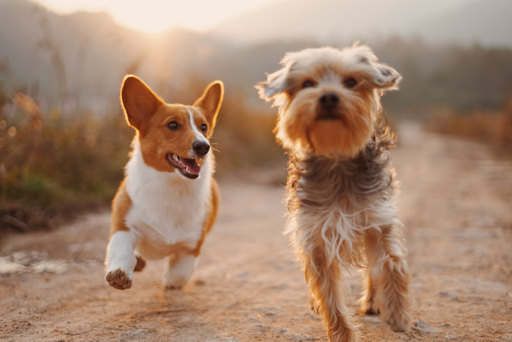

In [6]:
image = PIL.Image.open("img/dogs.jpg")
image.thumbnail((512, 512), PIL.Image.ANTIALIAS)
image

In [7]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std = torch.tensor([0.229, 0.224, 0.225])

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(imagenet_mean, imagenet_std),
])

In [8]:
def generate_attention(path, class_indexes, size=(224, 224)):
    
    ################################ Open and preprocess image
    image = PIL.Image.open(path)
    image.thumbnail(size, PIL.Image.ANTIALIAS)
    
    print("Image shape:", image.size)
    tensor = transform(image)[None]
        
    ################################ Run image through model
    with torch.no_grad():
        logits = model(tensor)[0]
    probs = torch.softmax(logits, dim=0)
    attention_map = probs[class_indexes].sum(dim=0)

    plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 3, 1)
    ax.axis("off")
    plt.imshow(image)

    ax = plt.subplot(1, 3, 2)
    ax.axis("off")
    plt.imshow(attention_map)
    
    ax = plt.subplot(1, 3, 3)
    ax.axis("off")
    ax.imshow(image)
    ax.imshow(attention_map, alpha=0.6, interpolation="bilinear", cmap="magma",
              extent=(0,image.size[0],image.size[1],0))


## See activation for "Yorkshire terrier" (Class index = 187)

Image shape: (224, 150)


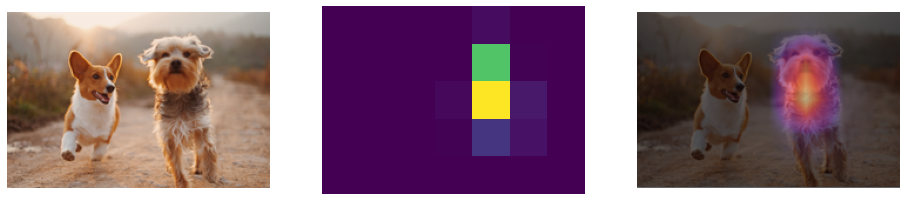

In [9]:
generate_attention("img/dogs.jpg", class_indexes=[187])

## See activation for "Corgi" (Class indexes = 263 & 264)
- 263: 'Pembroke, Pembroke Welsh corgi',
- 264: 'Cardigan, Cardigan Welsh corgi',

Image shape: (224, 150)


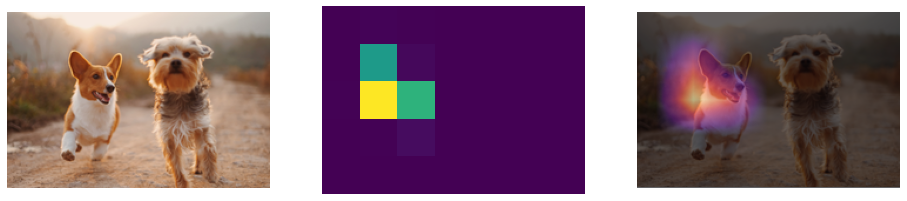

In [10]:
generate_attention("img/dogs.jpg", class_indexes=[263,264])

# Useful trick: Make image bigger

Image shape: (512, 342)


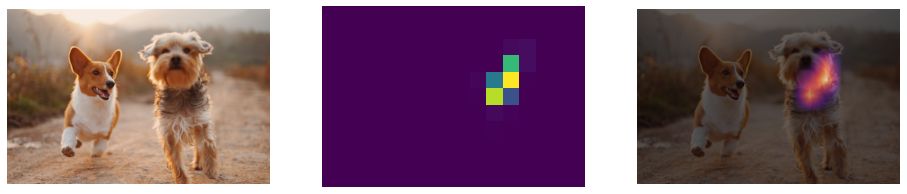

In [11]:
generate_attention("img/dogs.jpg", class_indexes=[187], size=(512, 512))

Image shape: (512, 342)


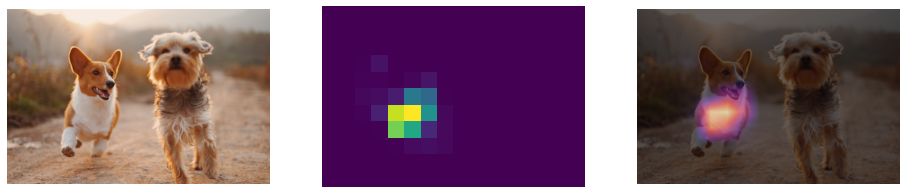

In [12]:
generate_attention("img/dogs.jpg", class_indexes=[263,264], size=(512, 512))